In [1]:
import sklearn
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from clustering import K_means_clustering, SVD, find_accuracy
import random
from itertools import combinations
import time
import json

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache = False)

### SVD decomposition of images

In [155]:
%%time

L = np.array(list(map(lambda x : SVD(x.reshape(28, -1), return_compressed=False, return_L = True), X[random.sample(range(len(X)), 100)])))


CPU times: user 50.3 ms, sys: 115 ms, total: 165 ms
Wall time: 234 ms


In [89]:
compressed = np.array(list(map(lambda x : SVD(x.reshape(28, -1), L = 3).flatten(), X)))
positions, max_distance = cluster_initialization(X, 10)

In [94]:
X, n_clusters, subset, max_iter, tolerance = compressed, 10, len(compressed), np.inf, 1e7

centroids = []
clusters = {}
for i, index in enumerate(positions[np.argmax(max_distance)]):
    centroids.append(X[index])
    clusters[i] = [X[index]]

data_distances_to_centroids = np.zeros((subset, 10))

for cluster_index in list(clusters.keys()):
    data_distances_to_centroids[:, cluster_index] = np.sum(
        (X[:subset] - centroids[cluster_index]) ** 2, axis=1
    )

old_residual = np.sum(data_distances_to_centroids)
residual = old_residual + tolerance * 2
no_iterations = 0

while np.abs(residual - old_residual) > tolerance and (no_iterations < max_iter):

    min_distance = np.argmin(data_distances_to_centroids, axis=1)

    for i in list(clusters.keys()):
        clusters[i] = X[min_distance == i]

    centroids = np.array(
        [np.mean(cluster, axis=0) for _, cluster in clusters.items()]
    )

    for cluster_index in list(clusters.keys()):
        data_distances_to_centroids[:, cluster_index] = np.sum(
            (X[:subset] - centroids[cluster_index]) ** 2, axis=1
        )

    old_residual = residual
    residual = np.sum(data_distances_to_centroids)

    no_iterations += 1



In [90]:
clusters = {}
for i, index in enumerate(positions[np.argmax(max_distance)]):
    clusters[i] = [index]

In [91]:
to_plot = np.array(list(clusters.values())).reshape(2, -1)

In [99]:
# to_plot = np.array(5, )
for i in range(5, 10):
    to_plot.append(centroids[i])

/Users/localadmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


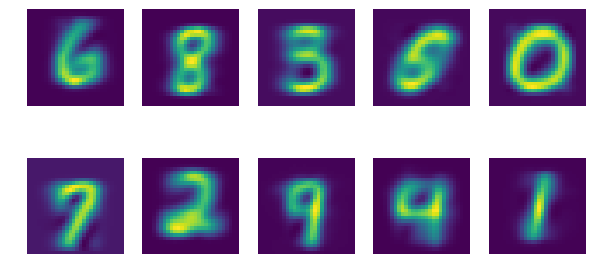

In [100]:
fig, ax = plt.subplots(2, 5, figsize = (10, 5))
to_plot = np.array(list(clusters.values())).reshape(2, -1)
for i in range(5):
    ax[0][i].imshow(centroids[i].reshape(28, -1))
    ax[0][i].axis('off')

for i in range(5, 10):
    ax[1][i - 5].imshow(centroids[i].reshape(28, -1))
    ax[1][i - 5].axis('off')

plt.savefig("SVD_final_centroids_L=3_Kmeans.pdf", format="pdf", bbox_inches="tight")

In [64]:
T, Accuracy = [], []

for i in range(5):
    print(i)
    t1 = time.time()
    centroids, min_distance = K_means_clustering(np.array(X), 10, subset = len(X), tolerance = 1e7)
    t2 = time.time()
    T.append(t2-t1)
    Accuracy.append(find_accuracy(10, y, min_distance))

0
1
2
3
4


In [224]:
importlib.reload(clustering)

<module 'clustering' from '/Users/localadmin/Desktop/LAOML/Sathish/clustering.py'>

In [13]:
%%time

degrees = range(1, 2)

for l in degrees:
    compressed_X = np.array(list(map(lambda x : SVD(x.reshape(28, -1), L = l).flatten(), X)))
    inter_accuracy = []
    inter_time = []
    for i in range(3):
        t1 = time.time()
        centroids, min_distance = K_means_clustering(compressed_X, 10, subset = len(X), tolerance = 1e7)
        t2 = time.time()
        inter_accuracy.append(find_accuracy(10, y, min_distance))
        inter_time.append(t2-t1)

    print(inter_accuracy, inter_time)

    print("With L of %d, clustering took %.2f seconds to achieve an accuracy of %.2f percent" % (l, np.mean(inter_time) , np.mean(inter_accuracy)))
    time_clustering[l] = np.mean(inter_time)
    clustering_accuracy[l] = np.mean(inter_accuracy)

[55.99142857142857, 52.43, 52.32857142857142] [146.54695391654968, 238.2428798675537, 308.7533061504364]
With L of 1, clustering took 231.18 seconds to achieve an accuracy of 53.58 percent


NameError: name 'time_clustering' is not defined

In [65]:
with open("simple_K_L_tuning.json", "r") as read_file:
    accuracy_time = json.load(read_file)

In [66]:
acc = list(map(lambda x: np.mean(np.array(x)[:, 0]), accuracy_time.values()))
T = list(map(lambda x: np.mean(np.array(x)[:, 1]), accuracy_time.values()))
Accuracy, Time = {}, {}
for i in range(1, 21): 
    Accuracy[i] = acc[i-1]
    Time[i] = T[i-1]

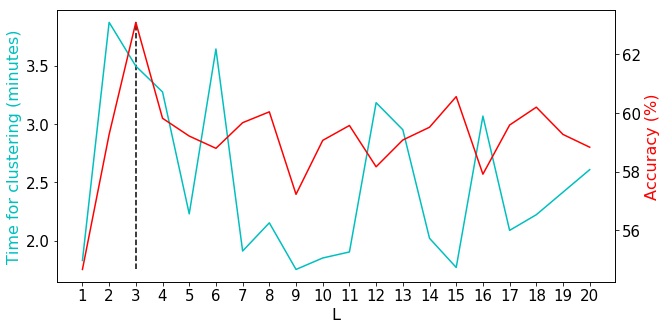

In [87]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
t = np.array(list(Time.values()))/60
ax.plot(list(Time.keys()), t, color = 'c')
ax.set_xlabel('L', fontsize = 16)
ax.set_ylabel('Time for clustering (minutes)', color = 'c', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=15)
ax2=ax.twinx()
ax2.plot(list(Accuracy.keys()), list(Accuracy.values()), color = 'r')
ax2.set_xlabel('L')
ax2.set_ylabel('Accuracy (%)', color = 'r', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax2.set_xticks(list(Accuracy.keys()));

ax.vlines(list(Accuracy.keys())[np.argmax(list(Accuracy.values()))], min(t), max(t), linestyles='dashed')

plt.savefig("SVD__optimize_L_standard_K_means.pdf", format="pdf", bbox_inches="tight");

In [182]:
t1 = time.time()
time.sleep(5)
t2 = time.time()

In [3]:
from itertools import product, permutations, combinations
import random

### Cluster initialization

The accuracy of K-means clustering depends on a better cluster initialization. 
If the centroids of the initialized clusters are very different from each other, then we can expect the clustering algorithm to better perform.
Hence, we find 10 samples from the entire dataset randomly and calculate the equilidean distance between them. We repeat this many times and choose the set with maximum equilidean distance. The chosen set should have the distinct centroids.

In [146]:
%%time

centroids, minimum_distance = K_means_clustering(X, y, len(X), max_iter = 50, tolerance = 1e-6)

CPU times: user 2min 13s, sys: 1min 13s, total: 3min 27s
Wall time: 3min 44s


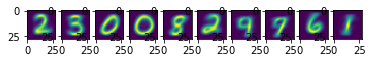

In [222]:
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(centroids[i].reshape(28, -1))

In [148]:
digit = np.zeros((10, ), dtype = int)
count = np.zeros((10, ), dtype = int)
cardinality = np.zeros((10, ), dtype = int)
for i in range(10):
    unique_digits = np.unique(y[min_distance == i], return_counts = True)
    digit[i] = unique_digits[0][np.argmax(unique_digits[1])]
    count[i] = unique_digits[1][np.argmax(unique_digits[1])]
    cardinality[i] = sum(unique_digits[1])

accuracy = (sum(count)/ sum(cardinality)) * 100 # %
print(accuracy)

59.93714285714285


### Kernelized k-means clustering

In [3]:
from clustering import polynomial_kernel

In [4]:
def cluster_initialization(X, nclusters, subset = 100):

    max_distance = []
    positions = []
    for i in range(nclusters * nclusters):
        random_positions = random.sample(range(len(X[:subset])), nclusters * nclusters)
        combos = []
        for i in range(10):
            combos.append(
                sum(
                    [
                        np.sum((X[:subset][indices[0]] - X[:subset][indices[1]]) ** 2)
                        for indices in list(
                            combinations(random_positions[nclusters * i : nclusters * (i + 1)], 2)
                        )
                    ]
                )
            )
            max_index = np.argmax(combos)
            positions.append(random_positions[nclusters * max_index : nclusters * (max_index + 1)])
            max_distance.append(combos[np.argmax(combos)])

    return positions, max_distance

In [5]:
positions, max_distance = cluster_initialization(X, 10, subset = 10000)

clusters = {}
for i, index in enumerate(positions[np.argmax(max_distance)]):
    clusters[i] = [index]

In [6]:
def polynomial_kernel(x1, x2):
    return (1 + x1.T * x2 ) ** 2

In [7]:
X = X.astype('float32')

In [8]:
%%time 

A_symmetry =  A + A.T - np.diag(np.diag(A))

NameError: name 'A' is not defined

In [9]:
subset = 10000
data_distances_to_centroids = np.zeros((subset, 10))


In [10]:
from itertools import permutations

In [67]:
A = np.zeros((10000, 10))
for i in range(10): A[:,i] = np.diag(A_symmetry)

B = np.zeros((10000, 10))
C = np.zeros((10, ))

In [68]:
old_residual = np.sum(data_distances_to_centroids)
residual = old_residual + 1
no_iterations = 0

while np.abs(old_residual - residual) > 0.0 and (no_iterations < 50):

    for i, cluster in clusters.items():
        B[:, i] = 2 / len(cluster) * np.sum(A_symmetry[cluster], axis = 0)
        C[i] = (1 / len(cluster)**2) * np.sum(np.array([A_symmetry[x[0], x[1]] if len(x) > 1 else A_symmetry[x[0], x[0]] for x in permutations(cluster)]))

    data_distances_to_centroids = A - B + C
    
    min_distance = np.argmin(data_distances_to_centroids, axis=1)

    for i in list(clusters.keys()):
        clusters[i] = np.where(min_distance == i)

    old_residual = residual
    residual = np.sum(data_distances_to_centroids)

    print(no_iterations, residual)

    no_iterations += 1

0 793875228562.0
1 113152092193016.0
2 113152092193016.0


In [72]:
min_dis

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [73]:
digit = np.zeros((10, ), dtype = int)
count = np.zeros((10, ), dtype = int)
cardinality = np.zeros((10, ), dtype = int)
for i in range(10):
    unique_digits = np.unique(y[:10000][min_distance == i], return_counts = True)
    digit[i] = unique_digits[0][np.argmax(unique_digits[1])]
    count[i] = unique_digits[1][np.argmax(unique_digits[1])]
    cardinality[i] = sum(unique_digits[1])

accuracy = (sum(count)/ sum(cardinality)) * 100 # %
print(accuracy)

36.46


In [7]:


data = X[453]

clusters = {0: np.hstack((range(200), range(600,len(data)))) ,
1: range(200, 600)
}

clusters = kernelized_k_means_clustering(data, clusters, kernel = polynomial_kernel)

Converged in: %d iterations 4


In [8]:
clustered_data = np.zeros((len(data), 1))

clustered_data[clusters[0]] = 0
clustered_data[clusters[1]] = 1

In [31]:
def exponential_kernel(x1, x2, p):
    return np.exp(-p * sum((x1 - x2)**2))


In [34]:
A = np.array([1, 2])
B = np.array([[3, 4], [5, 6]])

In [44]:
np.sum((X[0] - X[0:])**2, axis = 1)

array([      0., 5698302., 7690356., ..., 6904090., 7254810., 8667960.])

In [ ]:
adjacency_matrix = np.zeros((X.shape[0], X.shape[0]))

for i in range(X.shape[0]):
    adjacency_matrix[i] = np.exp(-1 * np.sum((X[i] - X[0:])**2, axis = 1))